In [4]:


from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import Compose, Invertd, SaveImaged
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
import torch
import json
from utils import PairFinder
from quant import masked_SUV_img

In [2]:
config_file = '/students/2023-2024/master/Shahpouri/DL_PET/config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']

In [3]:
from data_preparation import ExternalRadioSetHandling
from data_preparation import LoaderFactory

data_handler = ExternalRadioSetHandling(data_dir=fdg_data_dir, test_ratio=1)
train_files, val_files, test_files = data_handler.get_split_data()

print(f"Test data length: {len(test_files)}")
print(f"Validation data length: {len(val_files)}")
print(f"Train data length: {len(train_files)}")


loader_factory = LoaderFactory(
    train_files=None,
    val_files=None,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27], # For fdg data
    spatial_size = (168, 168, 400)
    # spatial_size = (336, 336, 640) # for Fdg data
    # spatial_size = (168, 168, 600) # for Fdg data
    )

# train_loader = loader_factory.get_loader('train', batch_size=4, num_workers=2, shuffle=True)
# val_loader = loader_factory.get_loader('val', batch_size=1, num_workers=2, shuffle=False)
test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)

Test data length: 98
Validation data length: 0
Train data length: 0


In [5]:
hint1 = 'dl3_18'
hint1 = 'dl4_23'
pair_finder_dl3_18 = PairFinder(f'{ga_data_dir}/NAC', f'{ga_data_dir}/MAC', ga_output_dir, hint1)
_, center_pairs_dyn  = pair_finder_dl3_18.find_file_triples()


hint2 = 'dl_final'
hint2 = 'final_4_26'
pair_finder_adcm = PairFinder(f'{ga_data_dir}/NAC',f'{ga_data_dir}/MAC', ga_output_dir, hint2)
_, center_pairs_adcm  = pair_finder_adcm.find_file_triples()

In [29]:
def load_and_prepare_data(pairs):
    concatenated_pred = []
    concatenated_ref = []
    for pair in pairs:
        # Apply the mask and get the predicted image data
        _, masked_predicted_img, masked_reference_img = masked_SUV_img(
            pair['nac'], pair['predicted'], pair['reference'], nac_factor=2, mac_factor=5, mask_val=0.3)
        concatenated_pred.extend(masked_predicted_img.ravel())  # Flatten and collect data
        concatenated_ref.extend(masked_reference_img.ravel())
    return concatenated_pred, concatenated_ref

# Obtain paths from the dictionaries for each center
center = 'C1'
adcm_paths = center_pairs_adcm[center]
imcm_paths = center_pairs_dyn[center]

# Load and prepare the data for statistical testing
imcm_data, mac_data = load_and_prepare_data(imcm_paths)
adcm_data, _ = load_and_prepare_data(adcm_paths)



In [25]:
import numpy as np
from scipy.stats import mannwhitneyu
from quant import load_nifti_image

# Perform the Mann-Whitney U Test
stat, p_value = mannwhitneyu(adcm_data, imcm_data, alternative='two-sided')

print("U-statistic:", stat)
print("P-value:", p_value)

# Interpretation of the result
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis - suggest the distribution of the two samples are significantly different.")
else:
    print("Do not reject the null hypothesis - suggest the distribution of the two samples are not significantly different.")


U-statistic: 187094849484524.5
P-value: 7.686508384218115e-23
Reject the null hypothesis - suggest the distribution of the two samples are significantly different.


In [31]:
stat, p_value = mannwhitneyu(mac_data, imcm_data, alternative='two-sided')

print("U-statistic:", stat)
print("P-value:", p_value)

alpha = 0.02  # significance level
if p_value < alpha:
    print("Reject the null hypothesis - suggest the distribution of the two samples are significantly different.")
else:
    print("Do not reject the null hypothesis - suggest the distribution of the two samples are not significantly different.")

U-statistic: 187998483815357.5
P-value: 1.2603516982102084e-58
Reject the null hypothesis - suggest the distribution of the two samples are significantly different.


In [ ]:
stat, p_value = mannwhitneyu(mac_data, adcm_data, alternative='two-sided')

print("U-statistic:", stat)
print("P-value:", p_value)

alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis - suggest the distribution of the two samples are significantly different.")
else:
    print("Do not reject the null hypothesis - suggest the distribution of the two samples are not significantly different.")

In [36]:
import pandas as pd


file_path = 'Results/combined_data.csv'
df = pd.read_csv(file_path)

df.head()

,Mean Error (SUV),Mean Absolure Error (SUV),Relative Error (SUV%),Absolure Relative Error (SUV%),Root Mean Squared Error,Peak Signal-to-Noise Ratio,Structual Similarity Index,Center,Dataset
0,-0.391218,1.948693,-3.455760,47.764912,7.159046,47.464313,0.857655,C1,ADCM
1,0.121809,1.248694,19.078541,48.547640,3.226209,39.599713,0.911650,C1,ADCM
2,0.593124,2.198104,17.919191,63.563060,6.744680,37.347102,0.837137,C2,ADCM
3,1.273347,2.408490,26.668924,63.049635,8.056123,35.262026,0.813911,C2,ADCM
4,2.883905,3.928055,37.376147,64.617671,20.673146,36.070237,0.899456,C3,ADCM


--------------
# Shapiro-Wilk test

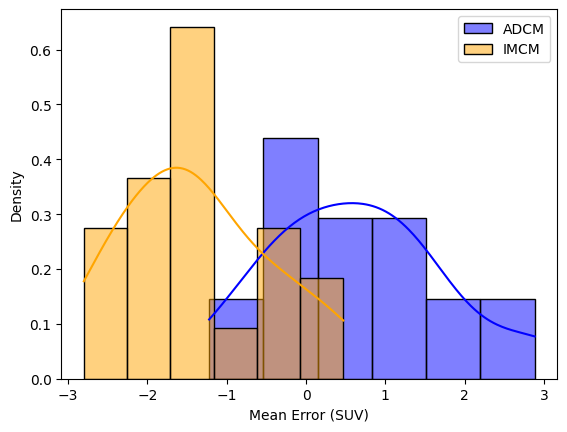

ADCM Normality Test: ShapiroResult(statistic=0.9626837089110806, pvalue=0.5987446057699778)
IMCM Normality Test: ShapiroResult(statistic=0.9645052085426011, pvalue=0.637188576544827)


In [42]:
import seaborn as sns
import scipy.stats as stats

# Assuming df_combined is your DataFrame and it includes 'Mean Error (SUV)' for both ADCM and IMCM
# Filter the data for ADCM and IMCM
df_adcm = df[df['Dataset'] == 'ADCM']['Mean Error (SUV)']
df_imcm = df[df['Dataset'] == 'Multi-Center']['Mean Error (SUV)']

# Plot the distributions
sns.histplot(df_adcm, color="blue", label="ADCM", kde=True, stat="density", common_norm=False)
sns.histplot(df_imcm, color="orange", label="IMCM", kde=True, stat="density", common_norm=False)
plt.legend()
plt.show()

# Conduct a Shapiro-Wilk test for normality
print("ADCM Normality Test:", stats.shapiro(df_adcm.dropna()))
print("IMCM Normality Test:", stats.shapiro(df_imcm.dropna()))


In [44]:
import scipy.stats as stats

# List of metrics to analyze
metrics = [
    "Mean Error (SUV)", "Mean Absolure Error (SUV)", "Relative Error (SUV%)",
    "Absolure Relative Error (SUV%)", "Root Mean Squared Error",
    "Peak Signal-to-Noise Ratio", "Structual Similarity Index"
]

# DataFrame for storing the normality test results
normality_results = []

# Loop over each metric to perform the Shapiro-Wilk test
for metric in metrics:
    data_adcm = df[df['Dataset'] == 'ADCM'][metric].dropna()
    data_imcm = df[df['Dataset'] == 'Multi-Center'][metric].dropna()
    result_adcm = stats.shapiro(data_adcm)
    result_imcm = stats.shapiro(data_imcm)
    
    # Store the results
    normality_results.append({
        'Metric': metric,
        'ADCM Statistic': result_adcm.statistic,
        'ADCM P-value': result_adcm.pvalue,
        'IMCM Statistic': result_imcm.statistic,
        'IMCM P-value': result_imcm.pvalue
    })

# Convert results to DataFrame for better visualization
df_normality = pd.DataFrame(normality_results)
df_normality


,Metric,ADCM Statistic,ADCM P-value,IMCM Statistic,IMCM P-value
0,Mean Error (SUV),0.962684,0.598745,0.964505,0.637189
1,Mean Absolure Error (SUV),0.973161,0.819726,0.902938,0.046832
2,Relative Error (SUV%),0.926644,0.133062,0.903215,0.047397
3,Absolure Relative Error (SUV%),0.934748,0.190480,0.813324,0.001375
4,Root Mean Squared Error,0.875041,0.014425,0.670732,0.000018
5,Peak Signal-to-Noise Ratio,0.826691,0.002222,0.944862,0.295736
6,Structual Similarity Index,0.963606,0.618108,0.973200,0.820480


------------------
# Step1: Mannwhitneyu

In [38]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Filter data by dataset
df_adcm = df[df['Dataset'] == 'ADCM']
df_imcm = df[df['Dataset'] == 'Multi-Center']

# Define the metrics to test
metrics = ['Mean Error (SUV)', 'Mean Absolure Error (SUV)', 'Relative Error (SUV%)', 'Absolure Relative Error (SUV%)', 'Root Mean Squared Error', 'Peak Signal-to-Noise Ratio', 'Structual Similarity Index']

# Initialize a dictionary to store the test results
test_results = {}

# Apply the Mann-Whitney U test for each metric
for metric in metrics:
    # Extract values for each group
    adcm_values = df_adcm[metric].dropna()
    imcm_values = df_imcm[metric].dropna()

    # Perform the test
    stat, p_value = mannwhitneyu(adcm_values, imcm_values, alternative='two-sided')
    
    # Store results in dictionary
    test_results[metric] = {'U-statistic': stat, 'P-value': p_value}

# Display the test results
for metric, result in test_results.items():
    print(f"{metric}: U-statistic = {result['U-statistic']}, P-value = {result['P-value']}")


Mean Error (SUV): U-statistic = 371.0, P-value = 3.987358896156635e-06
Mean Absolure Error (SUV): U-statistic = 330.0, P-value = 0.0004600727270090418
Relative Error (SUV%): U-statistic = 267.0, P-value = 0.0720454304673439
Absolure Relative Error (SUV%): U-statistic = 357.0, P-value = 2.3024709881112628e-05
Root Mean Squared Error: U-statistic = 364.0, P-value = 9.747975903084567e-06
Peak Signal-to-Noise Ratio: U-statistic = 286.0, P-value = 0.020734594207182492
Structual Similarity Index: U-statistic = 42.0, P-value = 2.0407139096244576e-05


-------------
# Step 2: False Discovery Rate (FDR) Correction
We'll apply the Benjamini-Hochberg procedure to correct the p-values obtained from multiple comparisons to control the false discovery rate.

In [45]:
import pandas as pd
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smm

# Filter data by dataset
df_adcm = df[df['Dataset'] == 'ADCM']
df_imcm = df[df['Dataset'] == 'Multi-Center']

# Define the metrics to test
metrics = ['Mean Error (SUV)', 'Mean Absolure Error (SUV)', 'Relative Error (SUV%)', 'Absolure Relative Error (SUV%)', 'Root Mean Squared Error', 'Peak Signal-to-Noise Ratio', 'Structual Similarity Index']

# Initialize a dictionary to store the test results
test_results = {}

# Collect all p-values for later correction
p_values = []

# Apply the Mann-Whitney U test for each metric
for metric in metrics:
    # Extract values for each group
    adcm_values = df_adcm[metric].dropna()
    imcm_values = df_imcm[metric].dropna()

    # Perform the test
    stat, p_value = mannwhitneyu(adcm_values, imcm_values, alternative='two-sided')
    
    # Store p-value for correction
    p_values.append(p_value)
    
    # Store results in dictionary without p-value initially
    test_results[metric] = {'U-statistic': stat}

# Correct p-values using FDR Benjamini-Hochberg
rej, p_vals_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Update test_results dictionary with corrected p-values
for (metric, p_val_corrected), rejected in zip(test_results.items(), p_vals_corrected):
    test_results[metric]['P-value'] = p_val_corrected
    test_results[metric]['Rejected'] = rejected

# Display the test results with q-values
for metric, result in test_results.items():
    print(f"{metric}: U-statistic = {result['U-statistic']}, P-value = {result['P-value']}, Rejected = {result['Rejected']}")



Mean Error (SUV): U-statistic = 371.0, P-value = {'U-statistic': 371.0, 'P-value': {...}, 'Rejected': 2.7911512273096448e-05}, Rejected = 2.7911512273096448e-05
Mean Absolure Error (SUV): U-statistic = 330.0, P-value = {'U-statistic': 330.0, 'P-value': {...}, 'Rejected': 0.0006441018178126585}, Rejected = 0.0006441018178126585
Relative Error (SUV%): U-statistic = 267.0, P-value = {'U-statistic': 267.0, 'P-value': {...}, 'Rejected': 0.0720454304673439}, Rejected = 0.0720454304673439
Absolure Relative Error (SUV%): U-statistic = 357.0, P-value = {'U-statistic': 357.0, 'P-value': {...}, 'Rejected': 4.02932422919471e-05}, Rejected = 4.02932422919471e-05
Root Mean Squared Error: U-statistic = 364.0, P-value = {'U-statistic': 364.0, 'P-value': {...}, 'Rejected': 3.4117915660795984e-05}, Rejected = 3.4117915660795984e-05
Peak Signal-to-Noise Ratio: U-statistic = 286.0, P-value = {'U-statistic': 286.0, 'P-value': {...}, 'Rejected': 0.024190359908379575}, Rejected = 0.024190359908379575
Structu

---------------------------
# Loading error metrics

In [47]:
import pandas as pd

# Load the CSV file into a DataFrame
df1 = pd.read_csv('Results/metric_data_ga.csv')
df2 = pd.read_csv('Results/metric_data_fdg.csv')
df_combined = pd.concat([df1, df2], ignore_index=True)
df_combined


,Mean Error (SUV),Mean Absolure Error (SUV),Relative Error (SUV%),Absolure Relative Error (SUV%),Root Mean Squared Error,Peak Signal-to-Noise Ratio,Structual Similarity Index,Center,Dataset
0,-0.391218,1.948693,-3.455760,47.764912,7.159046,47.464313,0.857655,C1,ADCM
1,0.121809,1.248694,19.078541,48.547640,3.226209,39.599713,0.911650,C1,ADCM
2,0.593124,2.198104,17.919191,63.563060,6.744680,37.347102,0.837137,C2,ADCM
3,1.273347,2.408490,26.668924,63.049635,8.056123,35.262026,0.813911,C2,ADCM
4,2.883905,3.928055,37.376147,64.617671,20.673146,36.070237,0.899456,C3,ADCM
...,...,...,...,...,...,...,...,...,...
77,-0.551712,0.630917,-44.485124,51.603632,0.805458,30.474281,0.687548,C7,Multi-Center
78,-0.693941,0.927650,-41.754761,66.728827,3.425571,44.385757,0.972591,C7,Multi-Center
79,-0.598760,0.668182,-45.177411,50.315126,0.950152,35.917202,0.788111,C7,Multi-Center
80,-0.730021,0.923421,-45.643741,66.818713,2.060167,38.224579,0.888959,C7,Multi-Center


In [48]:
import pandas as pd
import numpy as np
from scipy.stats import t
# Map centers C1 to C4 to 'C1-C4'
df_combined['Center'] = df_combined['Center'].replace(['C1', 'C2', 'C3', 'C4'], 'C1-C4')

vars = ['Mean Error (SUV)',	'Mean Absolure Error (SUV)',
'Relative Error (SUV%)', 'Absolure Relative Error (SUV%)',
'Root Mean Squared Error', 'Peak Signal-to-Noise Ratio','Structual Similarity Index']

for var in vars:
    stats_summary = df_combined.groupby(["Center", "Dataset"])[var].agg(["mean", "std", "count"]).reset_index()
    alpha = 0.05
    stats_summary['t-critical'] = stats_summary['count'].apply(lambda x: t.ppf(1 - alpha / 2, df=x - 1))

    # Calculate the standard error of the mean (SEM)
    stats_summary['SEM'] = stats_summary['std'] / np.sqrt(stats_summary['count'])

    # Calculate the 95% confidence intervals
    stats_summary['CI95% Lower'] = stats_summary['mean'] - (stats_summary['t-critical'] * stats_summary['SEM'])
    stats_summary['CI95% Upper'] = stats_summary['mean'] + (stats_summary['t-critical'] * stats_summary['SEM'])

    # Format Mean ± SD and CI 95%
    stats_summary['Mean ± SD'] = stats_summary.apply(lambda x: f"{x['mean']:.2f} ± {x['std']:.2f}", axis=1)
    stats_summary['CI 95%'] = stats_summary.apply(lambda x: f"[{x['CI95% Lower']:.2f}, {x['CI95% Upper']:.2f}]", axis=1)

    # Drop intermediate columns if not needed
    final_summary = stats_summary.drop(['mean', 'std', 'count', 't-critical', 'SEM', 'CI95% Upper', 'CI95% Lower'], axis=1)
    print(var)
    print(final_summary)
    print('--------------------------')


Mean Error (SUV)
  Center       Dataset     Mean ± SD          CI 95%
0  C1-C4          ADCM   0.78 ± 1.04   [-0.09, 1.65]
1  C1-C4  Multi-Center  -0.56 ± 0.74   [-1.18, 0.06]
2     C5          ADCM   0.59 ± 1.18   [-0.16, 1.34]
3     C5  Multi-Center  -1.92 ± 0.58  [-2.29, -1.56]
4     C6          ADCM   0.62 ± 0.68    [0.13, 1.11]
5     C6  Multi-Center  -0.46 ± 0.16  [-0.57, -0.34]
6     C7          ADCM  -0.01 ± 0.22   [-0.17, 0.14]
7     C7  Multi-Center  -0.61 ± 0.09  [-0.67, -0.55]
--------------------------
Mean Absolure Error (SUV)
  Center       Dataset    Mean ± SD        CI 95%
0  C1-C4          ADCM  2.45 ± 0.77  [1.81, 3.09]
1  C1-C4  Multi-Center  1.28 ± 0.37  [0.97, 1.59]
2     C5          ADCM  3.15 ± 0.62  [2.76, 3.54]
3     C5  Multi-Center  2.38 ± 0.76  [1.90, 2.87]
4     C6          ADCM  1.19 ± 0.37  [0.93, 1.45]
5     C6  Multi-Center  0.64 ± 0.13  [0.55, 0.73]
6     C7          ADCM  0.98 ± 0.32  [0.77, 1.19]
7     C7  Multi-Center  0.73 ± 0.12  [0.65, 0.81]
---

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import t

# Load the CSV file into a DataFrame
df1 = pd.read_csv('Results/metric_data_ga.csv')
df2 = pd.read_csv('Results/metric_data_fdg.csv')
df_combined = pd.concat([df1, df2], ignore_index=True)


df_combined['Center'] = df_combined['Center'].replace(['C1', 'C2', 'C3', 'C4', 'C5'], 'C1-C5')
df_combined['Center'] = df_combined['Center'].replace(['C6', 'C7'], 'C6-C7')
vars = ['Mean Error (SUV)',	'Mean Absolure Error (SUV)',
'Relative Error (SUV%)', 'Absolure Relative Error (SUV%)',
'Root Mean Squared Error', 'Peak Signal-to-Noise Ratio','Structual Similarity Index']

for var in vars:
    stats_summary = df_combined.groupby(["Center", "Dataset"])[var].agg(["mean", "std", "count"]).reset_index()
    alpha = 0.05
    stats_summary['t-critical'] = stats_summary['count'].apply(lambda x: t.ppf(1 - alpha / 2, df=x - 1))

    # Calculate the standard error of the mean (SEM)
    stats_summary['SEM'] = stats_summary['std'] / np.sqrt(stats_summary['count'])

    # Calculate the 95% confidence intervals
    stats_summary['CI95% Lower'] = stats_summary['mean'] - (stats_summary['t-critical'] * stats_summary['SEM'])
    stats_summary['CI95% Upper'] = stats_summary['mean'] + (stats_summary['t-critical'] * stats_summary['SEM'])

    # Format Mean ± SD and CI 95%
    stats_summary['Mean ± SD'] = stats_summary.apply(lambda x: f"{x['mean']:.2f} ± {x['std']:.2f}", axis=1)
    stats_summary['CI 95%'] = stats_summary.apply(lambda x: f"[{x['CI95% Lower']:.2f}, {x['CI95% Upper']:.2f}]", axis=1)

    # Drop intermediate columns if not needed
    final_summary = stats_summary.drop(['mean', 'std', 'count', 't-critical', 'SEM', 'CI95% Upper', 'CI95% Lower'], axis=1)
    print(var)
    print(final_summary)
    print('--------------------------')


Mean Error (SUV)
  Center       Dataset     Mean ± SD          CI 95%
0  C1-C5          ADCM   0.67 ± 1.10    [0.15, 1.18]
1  C1-C5  Multi-Center  -1.38 ± 0.93  [-1.81, -0.94]
2  C6-C7          ADCM   0.29 ± 0.58    [0.02, 0.55]
3  C6-C7  Multi-Center  -0.54 ± 0.15  [-0.60, -0.47]
--------------------------
Mean Absolure Error (SUV)
  Center       Dataset    Mean ± SD        CI 95%
0  C1-C5          ADCM  2.87 ± 0.75  [2.52, 3.22]
1  C1-C5  Multi-Center  1.94 ± 0.83  [1.55, 2.33]
2  C6-C7          ADCM  1.08 ± 0.35  [0.92, 1.24]
3  C6-C7  Multi-Center  0.69 ± 0.13  [0.63, 0.75]
--------------------------
Relative Error (SUV%)
  Center       Dataset       Mean ± SD            CI 95%
0  C1-C5          ADCM   -2.17 ± 20.85    [-11.93, 7.59]
1  C1-C5  Multi-Center  -12.38 ± 20.98   [-22.20, -2.56]
2  C6-C7          ADCM   34.08 ± 48.96    [11.80, 56.37]
3  C6-C7  Multi-Center   -39.70 ± 9.13  [-43.86, -35.55]
--------------------------
Absolure Relative Error (SUV%)
  Center       Dataset 

In [50]:
import pandas as pd
import numpy as np
from scipy.stats import t

# Load the CSV file into a DataFrame
df1 = pd.read_csv('Results/metric_data_ga.csv')
df2 = pd.read_csv('Results/metric_data_fdg.csv')
df_combined = pd.concat([df1, df2], ignore_index=True)

df_combined['Center'] = df_combined['Center'].replace(['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'], 'All')


for var in vars:
    stats_summary = df_combined.groupby(["Center", "Dataset"])[var].agg(["mean", "std", "count"]).reset_index()
    alpha = 0.05
    stats_summary['t-critical'] = stats_summary['count'].apply(lambda x: t.ppf(1 - alpha / 2, df=x - 1))

    # Calculate the standard error of the mean (SEM)
    stats_summary['SEM'] = stats_summary['std'] / np.sqrt(stats_summary['count'])

    # Calculate the 95% confidence intervals
    stats_summary['CI95% Lower'] = stats_summary['mean'] - (stats_summary['t-critical'] * stats_summary['SEM'])
    stats_summary['CI95% Upper'] = stats_summary['mean'] + (stats_summary['t-critical'] * stats_summary['SEM'])

    # Format Mean ± SD and CI 95%
    stats_summary['Mean ± SD'] = stats_summary.apply(lambda x: f"{x['mean']:.2f} ± {x['std']:.2f}", axis=1)
    stats_summary['CI 95%'] = stats_summary.apply(lambda x: f"[{x['CI95% Lower']:.2f}, {x['CI95% Upper']:.2f}]", axis=1)

    # Drop intermediate columns if not needed
    final_summary = stats_summary.drop(['mean', 'std', 'count', 't-critical', 'SEM', 'CI95% Upper', 'CI95% Lower'], axis=1)
    print(var)
    print(final_summary)
    print('-------------------------------')


Mean Error (SUV)
  Center       Dataset     Mean ± SD          CI 95%
0    All          ADCM   0.47 ± 0.88    [0.19, 0.75]
1    All  Multi-Center  -0.95 ± 0.78  [-1.19, -0.70]
-------------------------------
Mean Absolure Error (SUV)
  Center       Dataset    Mean ± SD        CI 95%
0    All          ADCM  1.95 ± 1.07  [1.61, 2.29]
1    All  Multi-Center  1.30 ± 0.86  [1.03, 1.57]
-------------------------------
Relative Error (SUV%)
  Center       Dataset       Mean ± SD            CI 95%
0    All          ADCM   16.40 ± 41.73     [3.23, 29.57]
1    All  Multi-Center  -26.38 ± 21.03  [-33.01, -19.74]
-------------------------------
Absolure Relative Error (SUV%)
  Center       Dataset      Mean ± SD          CI 95%
0    All          ADCM  69.01 ± 27.35  [60.37, 77.64]
1    All  Multi-Center  47.97 ± 10.53  [44.65, 51.29]
-------------------------------
Root Mean Squared Error
  Center       Dataset    Mean ± SD        CI 95%
0    All          ADCM  7.65 ± 6.99  [5.44, 9.85]
1    All  